# Imports

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import jinja2

In [19]:
path = 'C:/Users/max05/OneDrive/Bureau/DATA/_Portfolio/GCC_project/data/raw/'
data = pd.read_csv(path+'HR_comma_sep.csv')
data.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# Initial look 

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


# Renaming columns

Some column names are capitalised, others arn't

In [21]:
df0 = data.rename(columns = {
    'time_spend_company':'years_spent_company',
    'Work_accident':'work_accident',
    'Department':'department'
})

# Missing values

In [22]:
df0.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
years_spent_company      0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

There are no missing values in the dataset 

# Duplicates

In [23]:
print(f'{df0.duplicated().sum()} duplicated values in dataset')

3008 duplicated values in dataset


It seems highly unlikely that two employees would have the exact same scores on 11 different metrics.

We could investigate further but droping duplicates seems a reasonable course in this situation

In [24]:
df1 = df0.drop_duplicates(keep='first')
#Chack if duplicates were removed
df0.shape[0] - df1.shape[0]

3008

# Check for outliers 

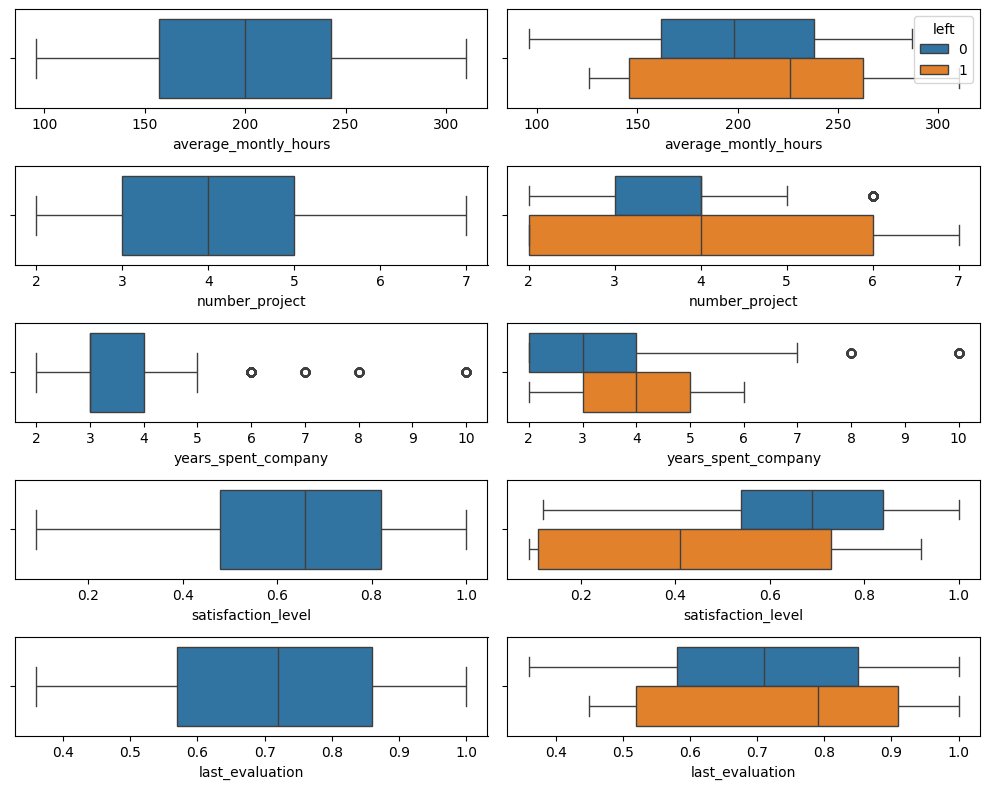

In [25]:
fig,ax = plt.subplots(5,2,figsize=(10,8))

#Boxplots of discrete and continuous variables 
sns.boxplot(data=df1,x='average_montly_hours',ax=ax[0,0])
sns.boxplot(data=df1,x='number_project',ax=ax[1,0])
sns.boxplot(data=df1,x='years_spent_company',ax=ax[2,0])
sns.boxplot(data=df1,x='satisfaction_level',ax=ax[3,0])
sns.boxplot(data=df1,x='last_evaluation',ax=ax[4,0])

# plots divided by departures 
sns.boxplot(data=df1,x='average_montly_hours',hue='left',ax=ax[0,1])
sns.boxplot(data=df1,x='number_project',hue='left',legend=None,ax=ax[1,1])
sns.boxplot(data=df1,x='years_spent_company',hue='left',legend=None,ax=ax[2,1])
sns.boxplot(data=df1,x='satisfaction_level',hue='left',legend=None,ax=ax[3,1])
sns.boxplot(data=df1,x='last_evaluation',hue='left',legend=None,ax=ax[4,1])

plt.tight_layout()

Most outliers are present in the years_spent_company metric, particularily in the stayed category.

There are allready some interesting paterns emerging in 'number_project','years_spent_company' and 'satisfaction_level' to be investigated later

In [26]:
#   Checking how many outliers are present in years_spent_company

upper_percentile = df1[['years_spent_company']].quantile(0.75).iloc[0]
lower_percentile = df1[['years_spent_company']].quantile(0.25).iloc[0]
iqr = upper_percentile-lower_percentile

outliers_df = df1[(df1['years_spent_company']>upper_percentile + 1.5*iqr) | (df1['years_spent_company']<lower_percentile - 1.5*iqr)]

print(f"{outliers_df.shape[0]} outliers in years_spent_company column wich is {(outliers_df.shape[0]/df1.shape[0]*100):.2f}% of the column")

824 outliers in years_spent_company column wich is 6.87% of the column


'years_spent_company' has 6.87% outliers in it. We will have to watch out when picking a model not to choose one sensitive to outliers

## Inspection of categorical metrics and of dimensions

## Correlation heatmap

<Axes: >

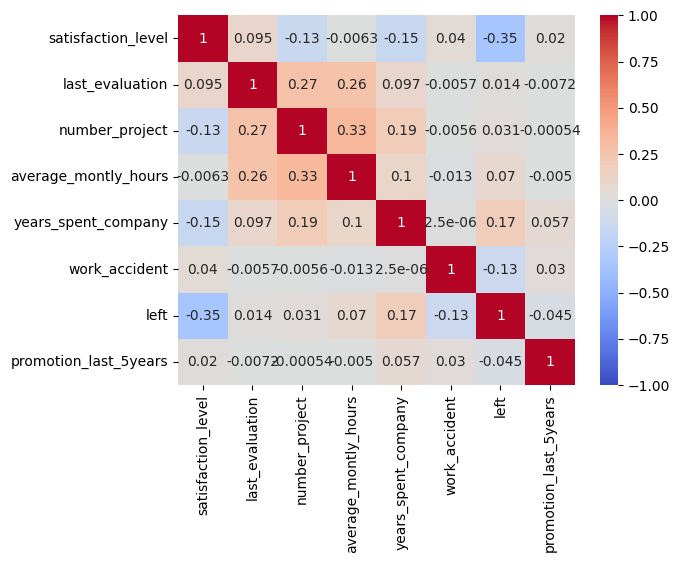

In [27]:
matrix = df1.corr(method='pearson',numeric_only=True)

sns.heatmap(matrix,vmin=-1,vmax=1,annot=True,cmap='coolwarm')

# Left column inspection

In [28]:
df1['left'].value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

# Work_accident column inspection

In [29]:
df1['work_accident'].value_counts(normalize=True)

work_accident
0    0.845718
1    0.154282
Name: proportion, dtype: float64

In [30]:
#   While we are at it, we might as well check the relation between work_accidents and departures
work_accident_df = (
    
    pd.DataFrame(
    df1[['work_accident','left']]
    .groupby(['work_accident'])
    .value_counts(normalize=False)
    .unstack()
    )
)

<Axes: xlabel='work_accident'>

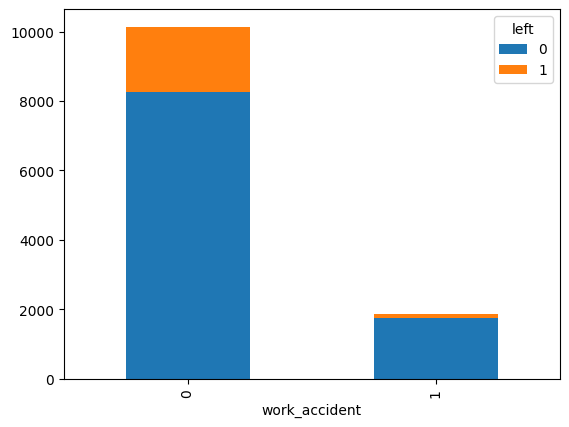

In [31]:
work_accident_df.plot.bar(stacked=True)

Based on this data, victims of a work accident seem more likely to leave. Mesures could be tought of to mitigate this issue.

<Axes: xlabel='average_montly_hours', ylabel='Count'>

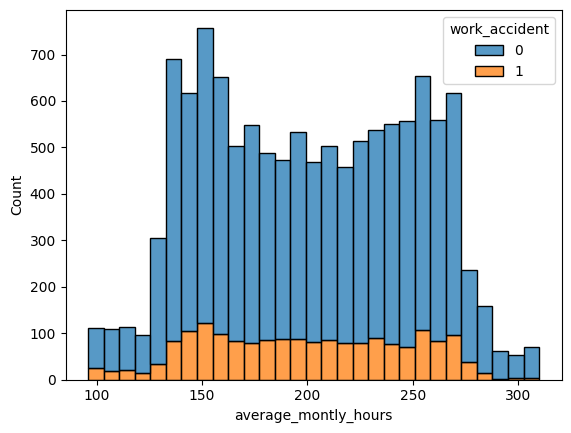

In [33]:
sns.histplot(df1,x='average_montly_hours',hue='work_accident',multiple='stack')

In [34]:
work_bins = [0,50,100,150,200,250,300]

accident_by_hours_worked_df = (
    df1.groupby([pd.cut(df1['average_montly_hours'],work_bins),'work_accident'])
    .size()
    .unstack()
)

accident_by_hours_worked_df['percent_of_accident'] = accident_by_hours_worked_df[1]*100 / (accident_by_hours_worked_df[0] + accident_by_hours_worked_df[1])
accident_by_hours_worked_df['total_of_workers'] = (accident_by_hours_worked_df[0] + accident_by_hours_worked_df[1])

(
    accident_by_hours_worked_df[['total_of_workers','percent_of_accident']]
    .fillna(0)
    .sort_values(by='percent_of_accident',ascending=False)
    .head(5)
)

C:\Users\max05\AppData\Local\Temp\ipykernel_7400\1167378915.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby([pd.cut(df1['average_montly_hours'],work_bins),'work_accident'])


work_accident,total_of_workers,percent_of_accident
average_montly_hours,,
"(50, 100]",67,23.880597
"(150, 200]",3717,16.411084
"(200, 250]",3536,15.639140
"(250, 300]",2318,14.797239
"(100, 150]",2261,14.329943


In [35]:
df1.groupby(['number_project'])['work_accident'].value_counts(normalize=True).unstack().drop(columns=0).rename(columns={1:'Percent of work accident'}).style.background_gradient(cmap='Blues',axis=0)

work_accident,Percent of work accident
number_project,
2,0.111252
3,0.175852
4,0.160651
5,0.156740
6,0.134383
7,0.013793


In [36]:
df1.groupby(['years_spent_company'])['work_accident'].value_counts(normalize=True).unstack().drop(columns=0).rename(columns={1:'Percent of work accident'}).style.background_gradient(cmap='Blues',axis=0)

work_accident,Percent of work accident
years_spent_company,
2,0.171821
3,0.149711
4,0.137656
5,0.140301
6,0.162362
7,0.138298
8,0.271605
10,0.233645


In [37]:
df1.groupby(['department'])['work_accident'].value_counts(normalize=True).unstack().drop(columns=0).sort_values(by=1,ascending=False).rename(columns={1:'Percent of work accident'})

work_accident,Percent of work accident
department,
RandD,0.171470
management,0.165138
support,0.164195
marketing,0.160475
product_mng,0.158892
sales,0.153751
technical,0.151070
IT,0.142418
accounting,0.140097


# Promotion_last_5years column inspection

In [38]:
df1['promotion_last_5years'].value_counts(normalize=True)

promotion_last_5years
0    0.983071
1    0.016929
Name: proportion, dtype: float64

In [39]:
promotion_df = (
    
    pd.DataFrame(
    df1[['promotion_last_5years','left']]
    .groupby('promotion_last_5years')
    .value_counts()
    .unstack()
    )
)

<Axes: xlabel='promotion_last_5years'>

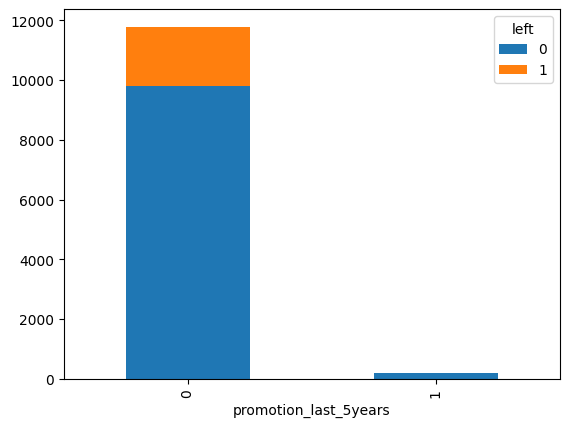

In [40]:
promotion_df.plot.bar(stacked=True)

In [41]:
promotion_df['percent_left'] = promotion_df[1] / (promotion_df[0]+promotion_df[1])
promotion_df

left,0,1,percent_left
promotion_last_5years,,,
0,9805,1983,0.168222
1,195,8,0.039409


Based on data, employees that did not get a raise in the last 5 years seem to be much more likely to leave. Further investigation could be beneficial. Also, there doesn't seem to be a lot of promoting in Saliford Motors. Creating new echelons could bring a sense of progression to keep engagement high.

In [42]:
bins = [0.2,0.4,0.6,0.8,1]

promotion_by_evaluation_df = (
    df1.groupby([pd.cut(df1['last_evaluation'],bins),'promotion_last_5years'])
    .size()
    .unstack()
)

promotion_by_evaluation_df['count_of_employees'] = promotion_by_evaluation_df[1] + promotion_by_evaluation_df[0]
promotion_by_evaluation_df['percent_promoted'] = promotion_by_evaluation_df[1]*100/(promotion_by_evaluation_df[0]+promotion_by_evaluation_df[1])

(
    promotion_by_evaluation_df
    .drop(columns=[0])
    .rename(columns={1:'Number of promotions'})
)

C:\Users\max05\AppData\Local\Temp\ipykernel_7400\3098094916.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df1.groupby([pd.cut(df1['last_evaluation'],bins),'promotion_last_5years'])


promotion_last_5years,Number of promotions,count_of_employees,percent_promoted
last_evaluation,,,
"(0.2, 0.4]",8,201,3.980100
"(0.4, 0.6]",56,3622,1.546107
"(0.6, 0.8]",77,3883,1.983003
"(0.8, 1.0]",62,4285,1.446908


From further inspection, promotions do not appear to be related to employees last evaluation. It could be worth investigating why that is the case.

In [43]:
(
    df1.groupby(['number_project'])
        ['promotion_last_5years']
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
        .sort_values(by=1,ascending=False)
        .drop(columns=[0])
        .rename(columns={1:'percent_of_promotion_given'})
)

promotion_last_5years,percent_of_promotion_given
number_project,
4,0.020624
3,0.017614
6,0.015738
5,0.014778
2,0.012010
7,0.000000


# Salary column inspection

In [44]:
salary_proportion = pd.DataFrame(df1['salary'].value_counts(normalize=True))
salary_proportion

,proportion
salary,
low,0.478692
medium,0.438746
high,0.082562


In [45]:
salary_df = (
    pd.DataFrame(
    df1[['salary','left']]
    .groupby('salary')
    .value_counts()
    .unstack()
    )
)

<Axes: xlabel='salary'>

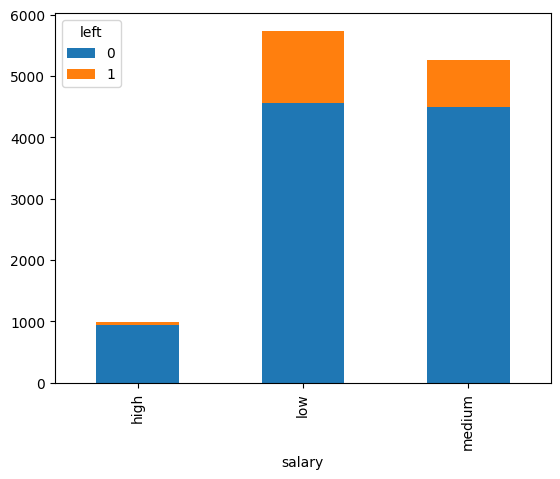

In [46]:
salary_df.plot.bar(stacked=True)

We can see from the data that higher paid staff are more likely to stay.

# Department column inspection